# LLM - Bielik - Fine tuning - part II

In [1]:
# ! pip install bitsandbytes
# ! pip install transformers
# ! pip install accelerate
# ! pip install peft
# ! pip install wandb
# ! pip install datasets
# ! pip install ipywidgets==8.1.3
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [2]:
import matplotlib.pyplot as plt

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

In [6]:


base_model_id = "speakleash/Bielik-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zjada\.cache\huggingface\hub\models--speakleash--Bielik-7B-v0.1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

In [8]:
def format_for_output(data):
    text = f"### Question: {data['question']}\n ### Answer: {data['answer']}"
    return text

In [9]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(format_for_output(prompt))

In [10]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='ft_output_data/esg_data_ft_20241004_160837_train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='ft_output_data/esg_data_ft_20241004_160837_eval.jsonl', split='train')

In [11]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/2699 [00:00<?, ? examples/s]

Map:   0%|          | 0/697 [00:00<?, ? examples/s]

In [12]:
tokenized_train_dataset

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask'],
    num_rows: 2699
})

3396


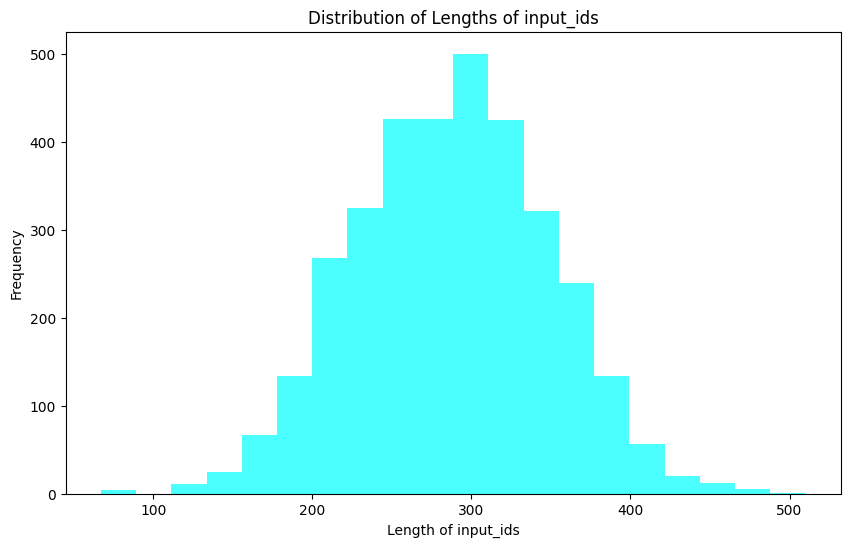

In [13]:
def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='cyan')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [14]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_with_truncation(prompt):
    result = tokenizer(
        format_for_output(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [15]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_with_truncation)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_with_truncation)

Map:   0%|          | 0/2699 [00:00<?, ? examples/s]

Map:   0%|          | 0/697 [00:00<?, ? examples/s]

3396


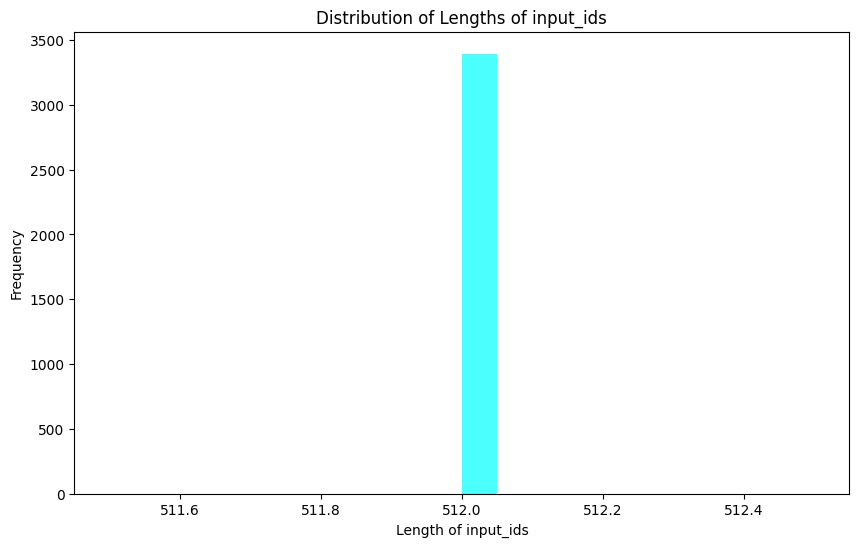

In [16]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [20]:
evaluation_prompt = 'O czym jest dyrektywa ESG? Odpowiedz w 200 slowach'

In [21]:
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(evaluation_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


O czym jest dyrektywa ESG? Odpowiedz w 200 slowach. Dyrektywa ESG to nowe przepisy, które mają na celu zwiększenie przejrzystości i odpowiedzialności firm w zakresie ich wpływu na środowisko naturalne, społeczeństwo oraz gospodarkę (ang. Environmental, Social and Governance). Wprowadza ona szereg obowiązków dla przedsiębiorstw, takich jak raportowanie danych niefinansowych czy też tworzenie strategii zrównoważonego rozwoju. Celem dyrektywy ESG jest promowanie działań proekologicznych i etycznych w biznesie oraz budowanie zaufania do rynku kapitałowego poprzez ujawnianie informacji o działaniach firmy wobec pracowników, klientów, partnerów biznesowych oraz społeczności lokalnej. Dyrektywa ta ma także pomóc inwestorom w podejmowaniu świadomych decyzji inwesty


In [22]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [23]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [24]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


In [25]:
from accelerate import Accelerator
accelerator = Accelerator()
model = accelerator.prepare_model(model)

In [26]:
import transformers
from datetime import datetime

project = "esg-legal-finetune"
base_model_name = "bielik_v1_7B"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
wandb: Currently logged in as: zvit3k (zvit3k-kodio). Use `wandb login --relogin` to force relogin


C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
25,0.792600,0.649566
50,0.569100,0.598761
75,0.567500,0.583208
100,0.533200,0.573770
125,0.531500,0.571374
150,0.556700,0.561332
175,0.499300,0.563312
200,0.528100,0.553690
225,0.512200,0.547481
250,0.511300,0.544694


C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\peft\utils\save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torc

TrainOutput(global_step=500, training_loss=0.5344273471832275, metrics={'train_runtime': 2711.7548, 'train_samples_per_second': 0.369, 'train_steps_per_second': 0.184, 'total_flos': 2.2105194233856e+16, 'train_loss': 0.5344273471832275, 'epoch': 0.37037037037037035})

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "speakleash/Bielik-11B-v2"
bnb_config = BitsAndBytesConfig(
    # llm_int8_enable_fp32_cpu_offload=True,
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True
)
# 


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "bielik_v2_11B-esg-legal-finetune/checkpoint-500")

In [ ]:
# eval_tokenizer.apply_chat_template(return_tensors="pt")

In [8]:
evaluation_prompt = "co to jest esg?"
model_input = eval_tokenizer(evaluation_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=200)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


co to jest esg?
 ### esg co to jest?
Etyka, środowisko i społeczna odpowiedzialność (ESG) to koncepcja, która obejmuje trzy główne obszary działalności przedsiębiorstw: etykę, środowisko i społeczną odpowiedzialność. ESG jest coraz bardziej istotne dla inwestorów i społeczeństwa, ponieważ firmy muszą działać zgodnie z zasadami etycznymi, dbać o środowisko naturalne i angażować się w działania społeczne. Wdrożenie ESG może przynieść korzyści dla firm, takie jak poprawa reputacji, zwiększenie zaufania inwestorów i klientów oraz zmniejszenie ryzyka finansowego. Dlatego coraz więcej firm decyduje się na wdrożenie strategii ESG w swojej działalności.
Etyka, środowisko i społeczna odpowiedzialność (ESG) to koncepcja, która obejmuje trzy główne obszary działalności przedsiębiorstw: etykę, środowisko i społeczną odpowiedzialność. ESG jest coraz bardziej istotne dla inwestorów i społeczeństwa, ponieważ firmy muszą działać zgodnie z zasadami etycznymi, dbać o środowisko naturalne i angażować się